In [30]:
import numpy as np
import pandas as pd
from cvx.covariance.ewma import iterated_ewma
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns

from markowitz import run_backtest, run_backtest_basic

# Load data

In [31]:
prices = pd.read_csv('../data/prices.csv', index_col=0, parse_dates=True).iloc[:, :]
returns = prices.pct_change().iloc[1:]
spreads = pd.read_csv('../data/spreads.csv', index_col=0, parse_dates=True).iloc[:, :]
volas = returns.ewm(halflife=63).std()

# Means

In [32]:
rng = np.random.default_rng(0)

IC = 0.3
means = IC * (IC * returns.rolling(5).mean().shift(-4) + volas * np.sqrt(1-IC**2) * rng.normal(size=returns.shape))

# Covariances

In [33]:
iewma_pair = (63, 250)

iterator = iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1], min_periods_vola=21, min_periods_cov=100)
choleskies = {iterate.time: pd.DataFrame(np.linalg.cholesky(iterate.covariance), index=iterate.covariance.index, columns=iterate.covariance.columns) for iterate in iterator}

# Markowitz

In [34]:
dates = np.intersect1d(means.dropna(axis=0, how='all').index.tolist(), list(choleskies.keys()))

logger.info('Running basic backtest')
backtest_basic = run_backtest_basic(means.loc[dates], choleskies, gamma=250)

logger.info('Running practical backtest')
backtest_practical = run_backtest(means.loc[dates], spreads.loc[dates], choleskies, gamma_risk=35, gamma_trade=5)

2024-11-10 16:46:31.232 | INFO     | __main__:<module>:3 - Running basic backtest
100%|██████████| 6067/6067 [01:05<00:00, 93.22it/s] 


# Metrics

In [35]:
def get_portfolio_returns(returns, spreads, backtest):
    _returns = returns.values
    _spreads = spreads.values
    _weights = backtest.weights
    _trades = np.abs(np.diff(_weights, axis=0))
    
    cost = np.hstack([np.array([0]), (_spreads[1:] * _trades).sum(axis=1)]) * 0.5

    return (_weights * _returns).sum(axis=1) - cost 

def drawdown(pnl):
    values = np.cumprod(1 + pnl)

    max_values = np.maximum.accumulate(values)
    return (values - max_values) / max_values

In [36]:
returns_basic = get_portfolio_returns(returns.loc[dates], spreads.loc[dates], backtest_basic)  
returns_practical = get_portfolio_returns(returns.loc[dates], spreads.loc[dates], backtest_practical)

metrics = pd.DataFrame(dtype=float)

metrics.loc['Mean', 'Basic'] = returns_basic.mean() * 250
metrics.loc['Mean', 'Practical'] = returns_practical.mean() * 250

metrics.loc['Risk', 'Basic'] = returns_basic.std() * np.sqrt(250)
metrics.loc['Risk', 'Practical'] = returns_practical.std() * np.sqrt(250)

metrics.loc['Sharpe', 'Basic'] = metrics.loc['Mean', 'Basic'] / metrics.loc['Risk', 'Basic']
metrics.loc['Sharpe', 'Practical'] = metrics.loc['Mean', 'Practical'] / metrics.loc['Risk', 'Practical']

metrics.loc['Drawdown', 'Basic'] = -drawdown(returns_basic).min()
metrics.loc['Drawdown', 'Practical'] = -drawdown(returns_practical).min()

metrics.round(3)

,Basic,Practical
Mean,-0.098,0.381
Risk,0.116,0.119
Sharpe,-0.848,3.193
Drawdown,0.994,0.112


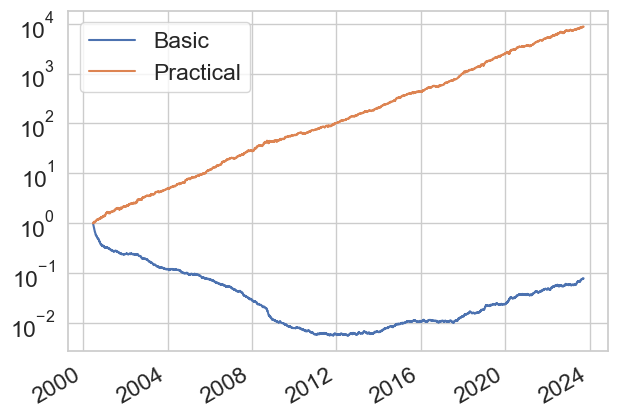

In [37]:
sns.set_theme(font_scale=1.5, style="whitegrid")
plt.figure(figsize=(6.5, 4.5))
plt.plot(dates, np.cumprod(1 + returns_basic), label=r'Basic')
plt.plot(dates, np.cumprod(1 + returns_practical), label=r'Practical')
plt.yscale('log')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()